# Stock Price Prediction #

## Load Packages ##

In [89]:
import numpy as np 
import pandas as pd 

np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Activation
from keras.layers import LSTM, GRU
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error

## Load Data ##

In [94]:
data_dir = "/home/lee/Documents/Datasets for GitHub/us_stocks_etfs_price_volume/"

symbols = ['SKX']

# symbols = ['skx', 'twou', 'nbix', 'abmd', 'bofi']

df = pd.DataFrame()
for symbol in symbols:
    single_stock = pd.read_csv(data_dir + "Stocks/" + symbol.lower() + '.us.txt', header=0)
    single_stock['symbol'] = symbol
    df = pd.concat([df, single_stock], ignore_index=True)
    df['Date'] = pd.to_datetime(df['Date'])
df.drop('OpenInt', axis=1, inplace=True)
df.set_index(['symbol', 'Date'], inplace=True, drop=False)

## Inspect Data ##

In [90]:
def look_at_dataset(df):

    print("dataframe shape: {}".format(df.shape))
    print("\n")

    print("preview data: \n")
    for i in list(range(0, len(df.columns), 8)):
        print(df.iloc[0:5, i:i+8])
    print("\n")

    print("summarize data: \n")
    for i in list(range(0, len(df.columns), 8)):
        print(df.iloc[:, i:i+8].describe())

look_at_dataset(df)

dataframe shape: (3201, 7)


preview data: 

                        Date    Open    High     Low   Close  Volume symbol
symbol Date                                                                
SKX    2005-02-25 2005-02-25  5.3000  5.3333  5.2567  5.3133  515400    SKX
       2005-02-28 2005-02-28  5.3167  5.3167  5.0667  5.0933  605100    SKX
       2005-03-01 2005-03-01  5.0833  5.2667  5.0700  5.2667  867900    SKX
       2005-03-02 2005-03-02  5.2167  5.3800  5.2000  5.3333  686700    SKX
       2005-03-03 2005-03-03  5.3500  5.4000  5.2933  5.3200  562500    SKX


summarize data: 

              Open         High          Low        Close        Volume
count  3201.000000  3201.000000  3201.000000  3201.000000  3.201000e+03
mean     12.676897    12.886845    12.458630    12.676894  2.501427e+06
std      10.013329    10.161441     9.853947    10.015809  2.355548e+06
min       1.780000     1.820000     1.733300     1.756700  1.026000e+05
25%       6.010000     6.130000     5.89000

### Check Missing ###

In [92]:
print("Number of records with missing value in each column: \n{}".format(df.isnull().sum()))

Number of records with missing value in each column: 
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
symbol    0
dtype: int64


### Visualize ###

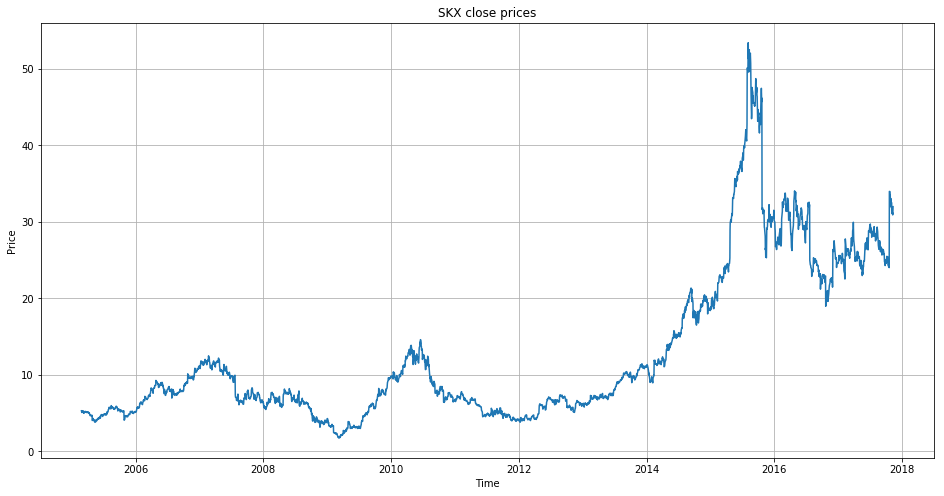

In [66]:
def plot_price(code, point):

    plt.figure(figsize = (16, 8))
    sns.lineplot(x="Date", y=point, data=df.loc[code, :])
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(code + " " + point.lower() + " prices")
    plt.show()
for i in symbols:
    plot_price(i, "Close")

## Prepare Data for Modeling ##

The below looks at one single stock. Next step is to automate this process so that it will take a ticker as argument and then output predictions. 

### Scale Prices ###

In [107]:
stocks_df = df.loc[symbols, :]
scaler = MinMaxScaler(feature_range=(0, 1))
stocks = scaler.fit_transform(stocks_df['Close'].to_frame())

### Split Train and Test ###

Use the first 80% of data for training. 

In [67]:
train_time_cutoff = int(len(stocks) * 0.80)
train = stocks[0:train_time_cutoff]
test = stocks[train_time_cutoff:]

### Reshape Data ###

How many historical prices do we use to predict the next day's price? Let's start with 2 for computation simplicity. Later we may optimize this value. 

In [74]:
def process_data(data, n_historical_records):
    dataX, dataY = [], []
    for i in range(len(data)-n_historical_records-1):
        window = data[i:(i+n_historical_records), 0]
        dataX.append(window)
        dataY.append(data[i + n_historical_records, 0])
    return np.array(dataX), np.array(dataY)

In [75]:
n_historical_records = 2

trainX, trainY = process_data(train, n_historical_records)
testX, testY = process_data(test, n_historical_records)

This model requires a 3-D input. 

In [83]:
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

## Modeling ##

### Define Model ###

During training we are interested in optimizing learning rate and batch size. 

In [78]:
model = Sequential()
model.add(GRU(256, input_shape = (1, n_historical_records), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256))
model.add(Dropout(0.4))
model.add(Dense(64,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 256)            198912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 740,737
Trainable params: 740,737
Non-trainable params: 0
_________________________________________________________________
None

### Define Optimizer ###

In [79]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr = 0.0005), \
              metrics = ['mean_squared_error'])

### Define Early Stopping Callback ###

In [ ]:
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

### Train Model ###

In [97]:
# For faster iteration, during training we try 20-50-100 epochs. Use early stopping if needed. 
# history = model.fit(trainX, trainY, epochs=100, batch_size=128, \
#                     verbose=0, callbacks=callbacks_list, validation_data=(testX,testY))
history = model.fit(trainX, trainY, epochs=100, batch_size=128, \
                    verbose=0, validation_data=(testX,testY))

### Plot Training History ###

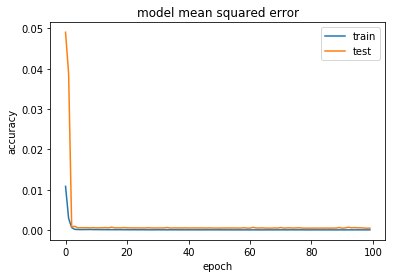

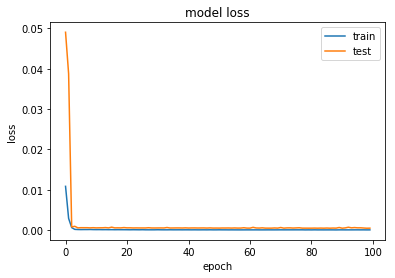

In [98]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### Make Predictions ###

In [125]:
pred = model.predict(testX)
pred = np.around(scaler.inverse_transform(pred), decimals=3)

In [87]:
# Scale the prices back
testY = testY.reshape(testY.shape[0], 1)
testY = scaler.inverse_transform(testY)

In [148]:
pred_vs_test = pd.concat([pd.Series(stocks_df.iloc[train_time_cutoff:, :]['Date'].tolist()), \
                          pd.Series(testY.flatten()), pd.Series(pred.flatten())], axis=1, \
                         ignore_index=True)
pred_vs_test.rename(columns={0: "date", 1: "actual", 2: "prediction"}, inplace=True)
pred_vs_test_long = pd.melt(pred_vs_test, id_vars=['date'], value_vars=["actual", 'prediction'])

In [164]:
del pred, testY, pred_vs_test

### Plot Predictions ###

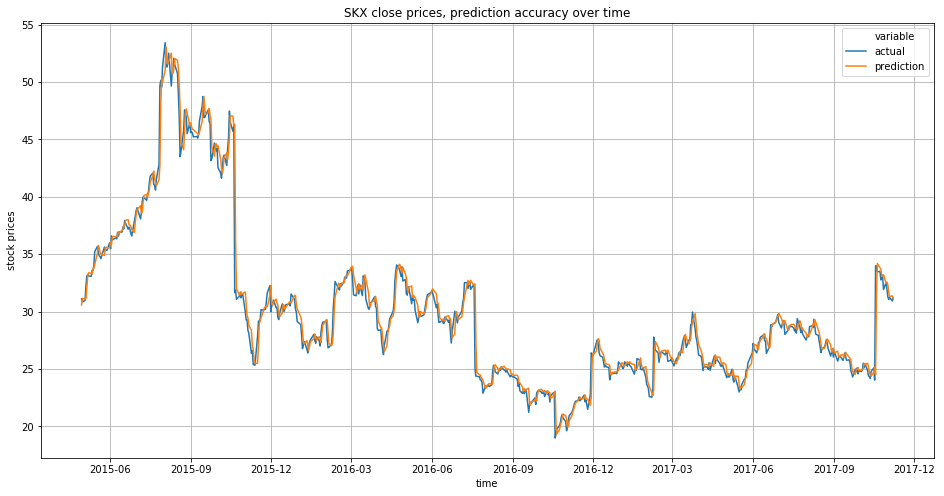

In [163]:
for code in symbols:
    # print("red - predicted, blue - actual")
    plt.figure(figsize = (16, 8))

    sns.lineplot(x="date", y="value", hue="variable", data=pred_vs_test_long)

    plt.xlabel('time')
    plt.ylabel('stock prices')
    plt.title(code + " " + "close" + " prices, prediction accuracy over time")

    plt.grid(True)
    plt.show()